In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from imblearn.over_sampling import RandomOverSampler

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_recall_fscore_support

In [ ]:
# load dataset
from google.colab import drive

drive.mount('/drive')
data = pd.read_csv('/drive/My Drive/Colab Notebooks/Cervical Cancer.csv')
data.head()

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,?,?,0,0,0,0,0,0,0,0


In [ ]:
data = data.drop(['Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes'], axis=1)
data = data.drop(['Smokes (years)', 'Smokes (packs/year)', 'Hormonal Contraceptives', 'IUD'], axis=1)
data = data.drop(['IUD (years)', 'STDs', 'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis'], axis=1)
data = data.drop(['STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis', 'STDs:syphilis', 'STDs:pelvic inflammatory disease'], axis=1)
data = data.drop(['STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:Hepatitis B', 'STDs:HPV'], axis=1)
data.head()

,Age,Hormonal Contraceptives (years),STDs (number),STDs:condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:genital herpes,STDs:HIV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0
1,15,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0
2,34,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0
3,52,3.0,0.0,0.0,0.0,0.0,0.0,0,1,0,1,0,0,0,0,0
4,46,15.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0


In [ ]:
data = data.replace('?', np.nan)

In [ ]:
data = data.apply(pd.to_numeric, axis=0)

In [ ]:
# Generating list of categorical factors:
temp=data.drop(columns=['Biopsy']).nunique()
cat=temp.loc[temp.values < 4].index.to_list()

# Updating null values to the least dominant category:
for factor in cat:
    data[factor] = data[factor].fillna(1)

In [ ]:
# Generating list of non-categorical factors:
temp=data.drop(columns=['Biopsy']).nunique()
non_cat=temp.loc[temp.values > 3].index.to_list()

# Implementing interpolation (with linear method), on known data for null values:
for factor in non_cat:
    data[factor] = data[factor].fillna(data[factor].median())

In [ ]:
len(data)

858

In [ ]:
data.drop_duplicates(inplace=True)
len(data)

480

In [ ]:
null_perc=data.isnull().sum()/len(data)*100
null=data.isnull().sum()
overview=pd.concat((null,null_perc,data.nunique()),axis=1, keys=['Null counts','Null %','Cardinality'])
overview

,Null counts,Null %,Cardinality
Age,0,0.0,44
Hormonal Contraceptives (years),0,0.0,40
STDs (number),0,0.0,5
STDs:condylomatosis,0,0.0,2
STDs:vulvo-perineal condylomatosis,0,0.0,2
STDs:genital herpes,0,0.0,2
STDs:HIV,0,0.0,2
STDs: Number of diagnosis,0,0.0,4
Dx:Cancer,0,0.0,2
Dx:CIN,0,0.0,2


In [ ]:
import numpy as np

print("Old Shape: ", data.shape)

Q1_age = data['Age'].quantile(0.25)
Q3_age = data['Age'].quantile(0.75)
IQR_age = Q3_age - Q1_age
lower_age = Q1_age - 1.5 * IQR_age
upper_age = Q3_age + 1.5 * IQR_age

Q1_hormonal = data['Hormonal Contraceptives (years)'].quantile(0.25)
Q3_hormonal = data['Hormonal Contraceptives (years)'].quantile(0.75)
IQR_hormonal = Q3_hormonal - Q1_hormonal
lower_hormonal = Q1_hormonal - 1.5 * IQR_hormonal
upper_hormonal = Q3_hormonal + 1.5 * IQR_hormonal

# Create Boolean masks for outlier rows based on the specified conditions
age_mask = (data['Age'] >= lower_age) & (data['Age'] <= upper_age)
hormonal_mask = (data['Hormonal Contraceptives (years)'] >= lower_hormonal) & (data['Hormonal Contraceptives (years)'] <= upper_hormonal)

# Apply the masks to filter out the outliers
filtered_data = data[age_mask & hormonal_mask]

print("New Shape: ", filtered_data.shape)

Old Shape:  (480, 16)
New Shape:  (438, 16)


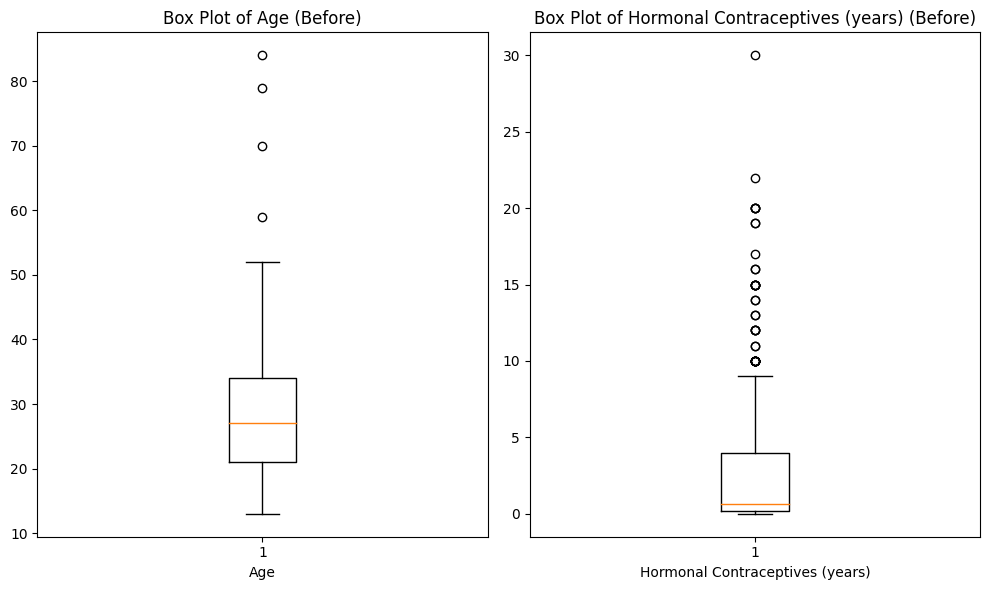

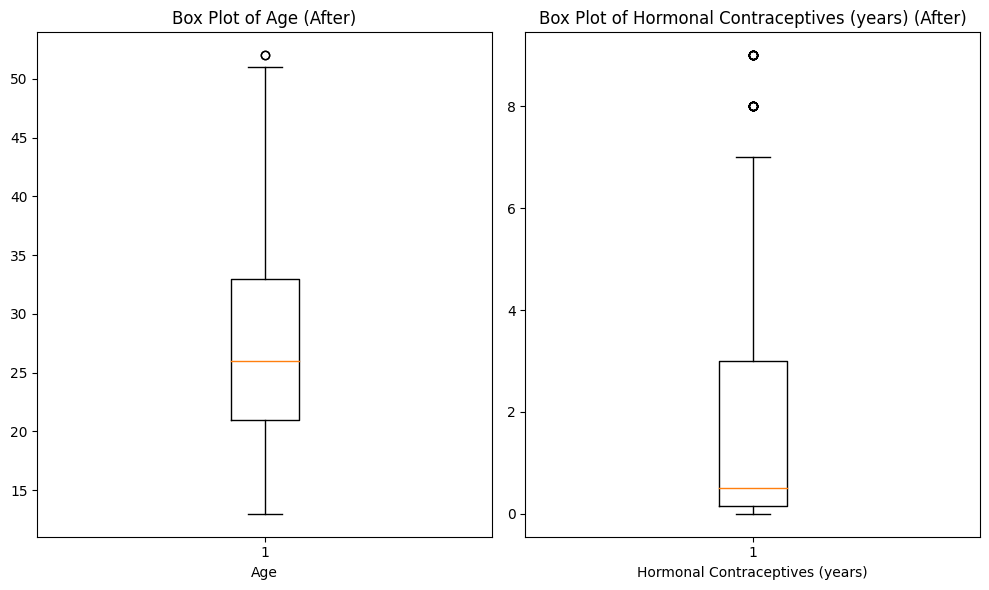

In [ ]:
import matplotlib.pyplot as plt

# Box plot before removing outliers
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.boxplot(data['Age'])
plt.title('Box Plot of Age (Before)')
plt.xlabel('Age')

plt.subplot(1, 2, 2)
plt.boxplot(data['Hormonal Contraceptives (years)'])
plt.title('Box Plot of Hormonal Contraceptives (years) (Before)')
plt.xlabel('Hormonal Contraceptives (years)')

plt.tight_layout()
plt.show()

# Box plot after removing outliers
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.boxplot(filtered_data['Age'])
plt.title('Box Plot of Age (After)')
plt.xlabel('Age')

plt.subplot(1, 2, 2)
plt.boxplot(filtered_data['Hormonal Contraceptives (years)'])
plt.title('Box Plot of Hormonal Contraceptives (years) (After)')
plt.xlabel('Hormonal Contraceptives (years)')

plt.tight_layout()
plt.show()

In [ ]:
filtered_data.describe()

,Age,Hormonal Contraceptives (years),STDs (number),STDs:condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:genital herpes,STDs:HIV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
count,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000
mean,27.315068,1.904348,0.283105,0.178082,0.175799,0.086758,0.125571,0.164384,0.036530,0.018265,0.036530,0.052511,0.070776,0.141553,0.077626,0.102740
std,7.993779,2.521401,0.688073,0.383019,0.381084,0.281802,0.331744,0.400698,0.187819,0.134061,0.187819,0.223311,0.256744,0.348989,0.267887,0.303966
min,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,0.160000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,33.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,52.000000,9.000000,4.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
y = filtered_data['Biopsy']
X = filtered_data.drop('Biopsy',axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)

In [ ]:
minmax_scale = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
X_train = minmax_scale.fit_transform(X_train)
X_val = minmax_scale.transform(X_val)
X_test = minmax_scale.transform(X_test)

#print(scaler.mean_)
#print(scaler.var_)
print(minmax_scale.data_max_)
print(minmax_scale.data_min_)
print(minmax_scale.scale_)

[52.  9.  4.  1.  1.  1.  1.  3.  1.  1.  1.  1.  1.  1.  1.]
[14.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[0.02631579 0.11111111 0.25       1.         1.         1.
 1.         0.33333333 1.         1.         1.         1.
 1.         1.         1.        ]


In [ ]:
len(X_val)

96

In [ ]:
from imblearn.over_sampling import RandomOverSampler
X_train,y_train=RandomOverSampler(sampling_strategy='minority').fit_resample(X_train,y_train)

In [ ]:
from tensorflow.keras import initializers

model = Sequential(
    [
        Dense(8, activation = 'relu', input_shape=[15]),
        Dense(4, activation = 'relu'),
        Dense(1, activation = 'sigmoid'),
    ]
)

In [ ]:
model.build()

In [ ]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 8)                 128       
                                                                 
 dense_57 (Dense)            (None, 4)                 36        
                                                                 
 dense_58 (Dense)            (None, 1)                 5         
                                                                 
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0004),
    metrics=['accuracy']
)

history = model.fit(X_train, y_train, 
                        epochs=75, batch_size=16,
                        validation_data=(X_val, y_val), 
                        shuffle=True)

Epoch 1/75
29/29 [==============================] - 1s 9ms/step - loss: 0.6634 - accuracy: 0.5218 - val_loss: 0.7072 - val_accuracy: 0.2045
Epoch 2/75
29/29 [==============================] - 0s 4ms/step - loss: 0.6566 - accuracy: 0.5939 - val_loss: 0.7035 - val_accuracy: 0.3636
Epoch 3/75
29/29 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6769 - val_loss: 0.7011 - val_accuracy: 0.4773
Epoch 4/75
29/29 [==============================] - 0s 4ms/step - loss: 0.6425 - accuracy: 0.7140 - val_loss: 0.6965 - val_accuracy: 0.6364
Epoch 5/75
29/29 [==============================] - 0s 3ms/step - loss: 0.6350 - accuracy: 0.7773 - val_loss: 0.6903 - val_accuracy: 0.7386
Epoch 6/75
29/29 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.8275 - val_loss: 0.6845 - val_accuracy: 0.8068
Epoch 7/75
29/29 [==============================] - 0s 3ms/step - loss: 0.6187 - accuracy: 0.8472 - val_loss: 0.6792 - val_accuracy: 0.8182
Epoch 8/75
29/29 [==

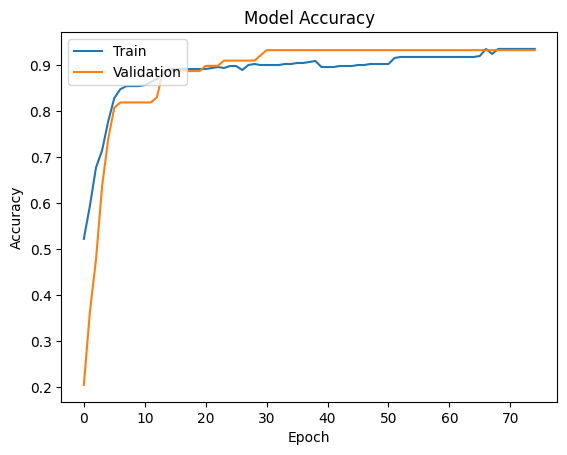

In [ ]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Model Accuracy')
plt.legend(loc='upper left')

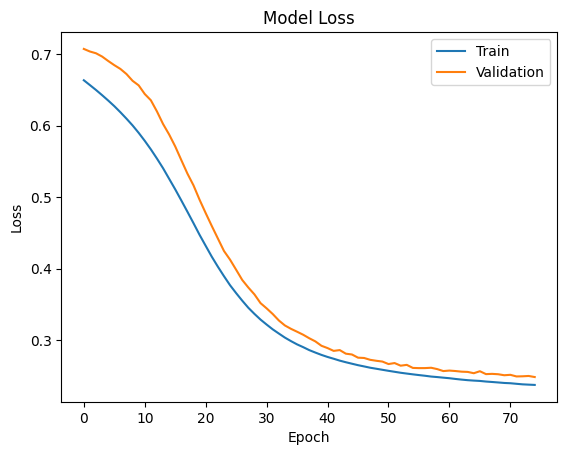

In [ ]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Model Loss')
plt.legend(loc='upper right')

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

3/3 [==============================] - 0s 4ms/step - loss: 0.1619 - accuracy: 0.9432
Test loss: 0.1619315892457962
Test accuracy: 0.9431818127632141


3/3 [==============================] - 0s 4ms/step

Confusion Matrix


Text(50.722222222222214, 0.5, 'True')

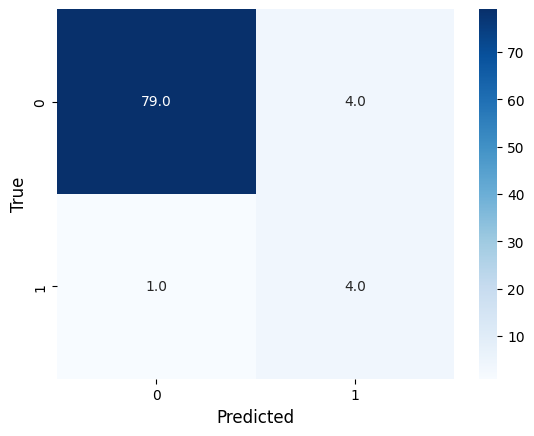

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
y_true = y_test
y_pred = model.predict(X_test)

# Make the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(np.round_(y_true), np.round_(y_pred))
print("\nConfusion Matrix")
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt = ".1f" )
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

In [ ]:
print(classification_report(np.round_(y_true),np.round_(y_pred)))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97        83
           1       0.50      0.80      0.62         5

    accuracy                           0.94        88
   macro avg       0.74      0.88      0.79        88
weighted avg       0.96      0.94      0.95        88



In [341]:
print(model.trainable_variables) 

[<tf.Variable 'dense_59/kernel:0' shape=(15, 8) dtype=float32, numpy=
array([[-0.14042377, -0.33765906,  0.39984262,  0.4442842 ,  0.59582806,
         0.5886223 ,  0.17347717,  0.4298    ],
       [ 0.5364404 , -0.166997  ,  0.59978217, -0.03684927,  0.1965916 ,
         0.02831785,  0.781248  , -0.11027024],
       [-0.47630176, -0.52078193,  0.3915488 ,  0.51122946,  0.11435711,
         0.22297244,  0.40085116, -0.19522946],
       [ 0.03866155,  0.3538852 , -0.08274988,  0.19309503,  0.31362587,
         0.13103087,  0.5487577 ,  0.46847874],
       [ 0.33878478,  0.3346225 ,  0.04664175, -0.34140646, -0.23825786,
         0.06979623, -0.3889009 , -0.0887088 ],
       [-0.03814982, -0.2829262 , -0.41494313, -0.42984644, -0.24873817,
         0.14549069, -0.5780815 , -0.12369459],
       [ 0.03552629,  0.10232487,  0.3140369 ,  0.3927455 ,  0.41332388,
         0.03752651, -0.08545879, -0.48276618],
       [ 0.447913  , -0.06914486, -0.34107298, -0.23064268, -0.31934908,
         0

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model')

In [ ]:
model.save('my_model.h5')

In [ ]:
from google.colab import files

files.download('saved_model/my_model/variables/variables.data-00000-of-00001')
files.download('saved_model/my_model/variables/variables.index')
files.download('saved_model/my_model/fingerprint.pb')
files.download('saved_model/my_model/keras_metadata.pb')
files.download('saved_model/my_model/saved_model.pb')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('my_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>